Creating plot...
Reading data...
Reading data DONE
Calculating delta T and tau...
421.07000000000005
Calculating delta T and tau DONE
Reading data...
Reading data DONE
Calculating delta T and tau...
289.54999999999995
Calculating delta T and tau DONE
Reading data...
Reading data DONE
Calculating delta T and tau...
491.80000000000007
Calculating delta T and tau DONE
Creating plot DONE


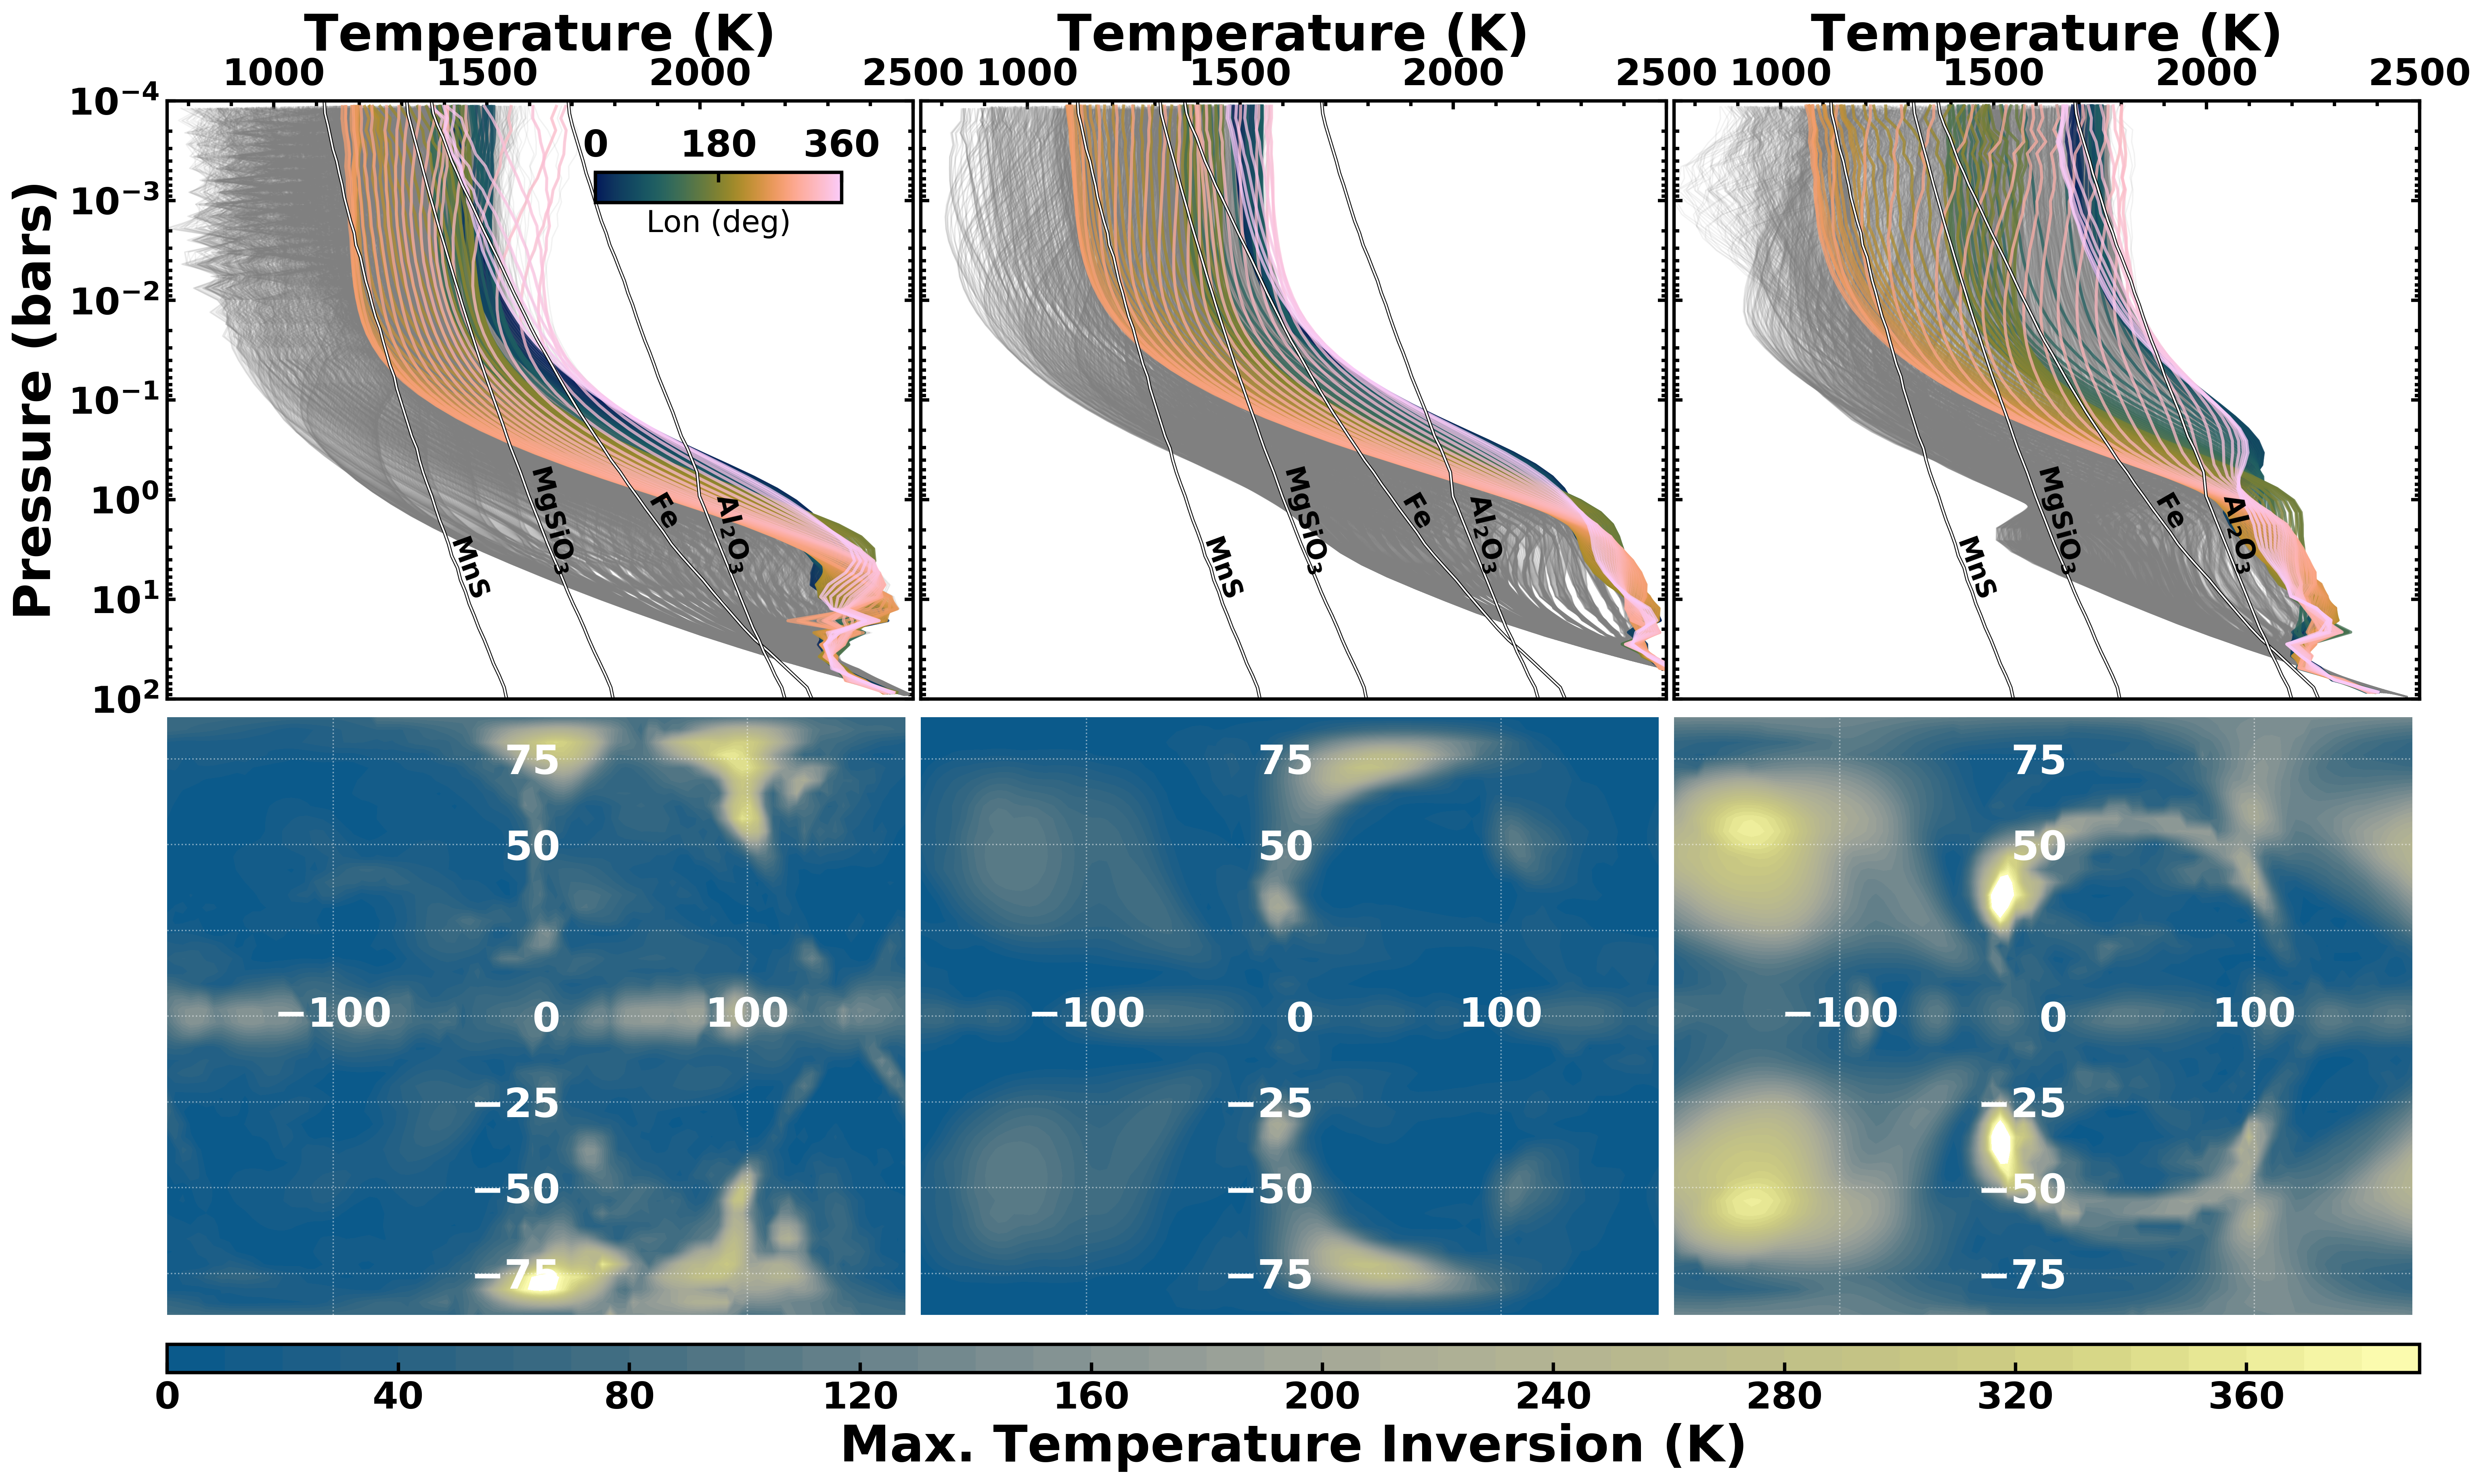

In [10]:
'''


Caleb K. Harada
charada@berkeley.edu


Map temperature inversions and show TP profiles (2 cases)


'''

### ----- INPUT/OUTPUT CONTROL ----- ###

cases = ['UPS-BIG-G-CLEAR',
         'UPS-LOW-G-CLEAR',
         'UPS-LOW-G-COM-CLOUDY']

condensation_data = '/media/imalsky/Samsung_T5/Hot-Jup-Data/Condensation_Ts.dat'         # condensation curves
output_file = '/home/imalsky/Desktop/planets-batlow.jpg'

fontsize = 24

Tmin = 0
Tmax = 400

# file info
NLAT = 48
NLON = 96
NTAU = 50
NPARAMS_list = [12, 12, 21]


### ----- IMPORT LIBRARIES ----- ###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, rc
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('/home/imalsky/isaac-style.txt')


# set rcParams ~~~~~~~~~~~~~~~~~~~~~~~~
rcParams['axes.linewidth'] =    2
rcParams['xtick.major.size'] =  6
rcParams['xtick.major.width'] = 2
rcParams['xtick.minor.size'] =  3
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.size'] =  6
rcParams['ytick.major.width'] = 2
rcParams['ytick.minor.size'] =  3
rcParams['ytick.minor.width'] = 2
font = {'size' : fontsize, 'weight' : 'bold'}
rc('font', **font)



# set up figure
print('Creating plot...')
fig, axes = plt.subplots(2, 3, figsize=(24,16))
plt.subplots_adjust(wspace=0.01, hspace=0.03)



for ind, case in enumerate(cases):

    ### ----- LOAD DATA FROM FILE ----- ###
    cloudreport = f'/media/imalsky/Samsung_T5/Hot-Jup-Data/UPS-PLANETS/OG-GCM-OUTPUT/{case}.txt'
    NPARAMS = NPARAMS_list[ind]

    print('Reading data...')
    data = np.loadtxt(cloudreport, skiprows=5)
    print('Reading data DONE')


    # separate data into more convenient arrays
    data = data.reshape((NLAT, NLON, NTAU, NPARAMS))

    lons = data[:,:,0,1][0] - 180
    lats = data[:,:,0,0][:,0]

    ### ----- CALCULATE TEMP INVERSIONS FOR PLOTTING ----- ###

    # empty array to store values
    delta_temps = np.zeros((NLAT, NLON))
    taus = np.zeros((NLAT, NLON))


    print('Calculating delta T and tau...')
    for i in range(NLAT):
        for j in range(NLON):

            max_dT = 0      # max temo inversion at this lat/lon
            current_dT = 0  # keep track of current continuous temp inversion

            for k in reversed(range(NTAU - 1)):

                # check if delta T is postive
                if data[i][j][k][5] > data[i][j][k + 1][5]:

                    # if delta T is positive, add it to the current continuous dT
                    dT = data[i][j][k][5] - data[i][j][k + 1][5]
                    current_dT += dT

                    # if the current dT is greater than the max dT, then it becomes the new max dT
                    if current_dT > max_dT:
                        max_dT = current_dT

                # if delta T is negative, reset the current continuous dT
                else:
                    current_dT = 0

            # save max dT to lat/lon grid
            delta_temps[i][j] = max_dT

    print (np.amax(delta_temps))
    print('Calculating delta T and tau DONE')


    # colormap
    cm_name = 'nuuk'
    cm_file = np.loadtxt(f'/home/imalsky/ScientificColourMaps7/{cm_name}/{cm_name}.txt')
    my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file)

    # add temperature map (must do twice to get rid of contour artifacts)
    temp_map = axes[1][ind].contourf(lons, lats, delta_temps, cmap=my_colors,
        levels=np.arange(Tmin, Tmax, 10))
    temp_map = axes[1][ind].contourf(lons, lats, delta_temps, cmap=my_colors,
        levels=np.arange(Tmin, Tmax, 10))

    # format temp axes
    axes[1][ind].set_xlim([-180, 180])
    axes[1][ind].set_xticks([-100, 100])
    axes[1][ind].spines['left'].set_position('zero')
    axes[1][ind].spines['bottom'].set_position('zero')
    axes[1][ind].spines['left'].set_color('none')
    axes[1][ind].spines['right'].set_color('none')
    axes[1][ind].spines['top'].set_color('none')
    axes[1][ind].spines['bottom'].set_color('none')
    axes[1][ind].tick_params(
        axis='both',
        which='both',
        top=False,
        bottom=False,
        right=False,
        left=False,
        labelcolor='w',
        labelsize=fontsize,
        pad=-12
        )
    axes[1][ind].yaxis.get_major_ticks()[5].label1.set_visible(False)
    axes[1][ind].grid(color='w',alpha=0.5,ls=':')




    ### tp profiles ###

    # adjust tick marks on both axes

    axes[0][ind].tick_params(axis='both',
                  which='both',
                  direction='in',
                  top = True,
                  right = True)
    axes[0][ind].tick_params(axis='both',
                  which='major',
                  length=5)




    # plot all TP-profiles (expensive)
    for i in range(NLAT):

        for j in range(96):

            axes[0][ind].semilogy(data[i][j][:,5], data[i][j][:,4], '-',
                lw=0.8, alpha=0.1, color=(0.5, 0.5, 0.5))


    colors = np.linspace(0, 1, 96)

    # set color cycle
    color_idx = 0

    # colormap
    cm_name = 'batlow'
    cm_file = np.loadtxt(f'/home/imalsky/ScientificColourMaps7/{cm_name}/{cm_name}.txt')
    my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file)


    # plot colored equatorial TP-profiles
    for i in range(96):

        if max(data[24][i][:,5] < 3000):
            axes[0][ind].semilogy(data[24][i][:,5], data[24][i][:,4], '-',
                lw=1.8, alpha=0.75, color=my_colors(colors[color_idx]))

        color_idx += 1

    # plot cloud condensation curves
    press_con, MgSiO3_cond, Fe_cond, Al2O3_cond, MnS_cond = np.loadtxt(condensation_data, usecols=(0,14,10,13,4), unpack=True)

    axes[0][ind].semilogy(MgSiO3_cond, press_con, 'k-', lw=2)
    axes[0][ind].semilogy(MgSiO3_cond, press_con, 'w-', lw=1)
    axes[0][ind].text(1590, 5, 'MgSiO$_3$', rotation=-75, fontsize=16)

    axes[0][ind].semilogy(Fe_cond, press_con, 'k-', lw=2)
    axes[0][ind].semilogy(Fe_cond, press_con, 'w-', lw=1)
    axes[0][ind].text(1865, 2, 'Fe', rotation=-60, fontsize=16)

    axes[0][ind].semilogy(Al2O3_cond, press_con, 'k-', lw=2)
    axes[0][ind].semilogy(Al2O3_cond, press_con, 'w-', lw=1)
    axes[0][ind].text(2025, 5, 'Al$_2$O$_3$', rotation=-77, fontsize=16)

    axes[0][ind].semilogy(MnS_cond, press_con, 'k-', lw=2)
    axes[0][ind].semilogy(MnS_cond, press_con, 'w-', lw=1)
    axes[0][ind].text(1400, 10, 'MnS', rotation=-70, fontsize=16)


    axes[0][ind].set_xlim([750, 2500])
    axes[0][ind].set_ylim([1e-4, 1e+2])

    axes[0][ind].xaxis.set_major_locator(ticker.MultipleLocator(500))
    axes[0][ind].xaxis.set_minor_locator(ticker.MultipleLocator(100))

    axes[0][ind].invert_yaxis()
    axes[0][ind].xaxis.set_ticks_position('top')
    axes[0][ind].xaxis.set_label_position('top')
    axes[0][ind].set_xlabel('Temperature (K)', weight='bold')


# tp labels
axes[0][0].set_ylabel('Pressure (bars)', weight='bold')
axes[0][1].get_yaxis().set_ticklabels([])
axes[0][2].get_yaxis().set_ticklabels([])


# add colorbar
axin = inset_axes(axes[0][0],
                width="33%",  # width = 50% of parent_bbox width
                height="5%",  # height : 5%
                loc='upper right',
                borderpad=2.5)

# colorbars

sm = plt.cm.ScalarMappable(cmap=my_colors, norm=plt.Normalize(vmin=0, vmax=360))
sm._A = []
tp_cbar = plt.colorbar(sm, cax=axin, orientation='horizontal', ticks=[0, 180, 360])
tp_cbar.set_label('Lon (deg)', fontsize=18)
axin.xaxis.set_ticks_position('top')

temp_cbar = fig.colorbar(temp_map, ax=axes.ravel().tolist(), location='bottom', aspect=80, pad=0.02)
temp_cbar.set_label('Max. Temperature Inversion (K)', weight='bold')



print('Creating plot DONE')

fig.savefig(output_file, bbox_inches='tight', dpi=100)


